In [1]:
import importlib
from moma_analysis import *

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [9]:
# load dataset
ds = 4
paths = {1:'data/191120_traces.csv', 2:'data/200114_traces_select_new.csv', 3:'data/200617_traces.csv', 4:'../200721_split/200721_traces.csv'}
df = pd.read_csv(paths[ds])

fs = 6
t_cutoff = 50
if ds==3:
    t_cutoff = 35
if ds==4:
    t_cutoff = 25


# selection of traces
selection = df['id'].unique()  # all
# For now only use traces that look good right away, comment if wanted
#for val in [17, 20, 40, 53, 3]:
#    selection = selection[selection!=val]
# individual selection
#selection = [59,89]

# initialise features to be collected per trace
T = []
peaks = []
dec = []
rsq = []
intervals = []
av_g_intervals = []
av_g_period = []
phases = np.zeros((len(selection), fs*t_cutoff))

# loop over selection
for j, i in enumerate(selection):
    # calculate phases
    name, t, sig = load_data(i, df)
    t_interp, s_interp, i_cutoff = sig_interp(sig, t, t_cutoff, fs)
    cutoff_freq = 1/5
    s_lp = butter_lowpass_filter_noshift(s_interp, cutoff_freq, 6, order=2)
    window_length = 21
    #s_smooth = savgol_filter(s_interp, window_length, 3, mode='interp')
    s_smooth = savgol_filter(s_lp, window_length, 3, mode='interp')
    s_analytical = hilbert(s_smooth)
    #s_analytical = hilbert(s_lp)
    phases[j] = np.angle(s_analytical)

    
    # calculate decay
    name, t, sig = load_data(i, df)
    t_interp, s_interp, i_cutoff = sig_interp(sig, t, t_cutoff, fs)
    s_smooth = savgol_filter(s_interp, 31, 3)
    peaks_i, T_i = peak_locations(s_smooth, 6)
    dec_i, rsq_i, intervals_i = peak_decay(peaks_i, T_i, t_interp, s_interp, i)
    intervals.append(intervals_i)
    T.append(T_i)
    peaks.append(peaks_i)
    dec.append(dec_i)
    rsq.append(rsq_i)
    
    # calculate growth rate
    name, t, t2, area, area2, switch = load_area(i, df)
    div = div_events(t, area)
    div2 = div_events(t2, area2)
    g_rate = growth_rate(t, div, 6)
    g_rate2 = growth_rate(t2, div2, 6)
    cond = (not switch is None) & (not np.isnan(switch))
    if cond:
        g_rate_switch = np.concatenate([g_rate[:int(switch)], g_rate2[int(switch):]])
    else: 
        g_rate_switch = g_rate
    
    # calculate average growth rate in intervals of peak decay
    av_g_intervals_i = []
    for interval in intervals_i:
        indices = (6*interval).astype(int)
        av_g_intervals_i.append(np.mean(g_rate_switch[indices[0]:indices[1]]))
    av_g_intervals.append(av_g_intervals_i)
    
    # calculate average growth rate of period
    av_g_period_i = []
    for i in range(len(T_i)):
        indices = [(fs*peaks_i[i]).astype(int), (fs*peaks_i[i+1]).astype(int)]
        av_g_period_i.append(np.mean(g_rate_switch[indices[0]:indices[1]]))
    av_g_period.append(av_g_period_i)
    

    
# ACF and xcorr

crosscorr_sum = np.zeros(fs*t_cutoff)
autocorr_growth_sum = np.zeros(fs*t_cutoff)
autocorr_sum = np.zeros(fs*t_cutoff)
for j, i in enumerate(selection):
    # try acf
    name, t, sig = load_data(i, df)
    t_interp, s_interp, i_cutoff = sig_interp(sig, t, t_cutoff, fs)
    autocorr_sum += autocorr(s_interp)
    
    # calculate growth rate
    name, t, t2, area, area2, switch = load_area(i, df)
    div = div_events(t, area)
    div2 = div_events(t2, area2)
    g_rate = growth_rate(t, div, 6)
    g_rate2 = growth_rate(t2, div2, 6)
    cond = (not switch is None) & (not np.isnan(switch))
    if cond:
        g_rate_switch = np.concatenate([g_rate[:int(switch)], g_rate2[int(switch):]])
        t_switch = np.concatenate([t[:int(switch)], t2[int(switch):-1]])
    else: 
        g_rate_switch = g_rate
        t_switch = t[:-1]
    t_g_interp, g_interp, i_cutoff = sig_interp(g_rate_switch, t_switch, t_cutoff, fs)
    autocorr_growth_sum += autocorr(g_interp)
    
    crosscorr_sum += crosscorr(s_interp, g_interp)

crosscorr_avg = crosscorr_sum/len(selection)
autocorr_avg = autocorr_sum/len(selection)
autocorr_growth_avg = autocorr_growth_sum/len(selection)


# collect features
av_g_intervals = np.concatenate(np.array(av_g_intervals))
av_g_period = np.concatenate(np.array(av_g_period))
# handle empty intervals
delete_empty_elements = []
intervals = np.array(intervals)
for i, interval in enumerate(intervals):
    if interval.shape==(0,):
        delete_empty_elements.append(i)
intervals = np.delete(intervals, delete_empty_elements)
intervals = np.concatenate(np.array(intervals))
Ti = T.copy()
T = np.concatenate(np.array(T))
dec = np.concatenate(np.array(dec))
rsq = np.concatenate(np.array(rsq))
uphases = np.unwrap(phases)
# does the following make sense?
phases0 = np.zeros_like(phases)
uphases0 = np.zeros_like(uphases)
for i in range(len(selection)):
    uphases0[i] = uphases[i]-uphases[i,0]
    phases0[i] = phases[i]-phases[i,0]

No fit for id 3 peak 2
No fit for id 5 peak 2
No fit for id 10 peak 0
No fit for id 12 peak 0
No fit for id 13 peak 0


## Investigate Dephasing
- Create dephasing trace from period distribution
    - stastical process generator?
- Mutual information, fisher information of dephasing

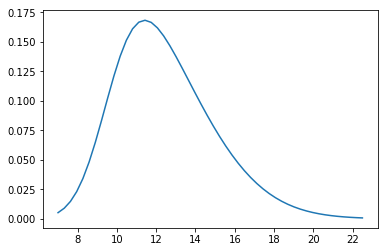

In [100]:
from scipy.stats import skewnorm
X = np.linspace(min(T), max(T))
plt.plot(X, skewnorm.pdf(X, *skewnorm.fit(T)))

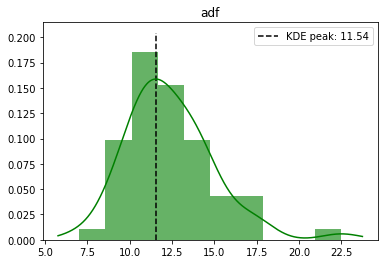

In [101]:
hist_kde(T, 'adf')

In [6]:
mean, var, skew, kurt = skewnorm.stats(*skewnorm.fit(T), moments='mvsk')

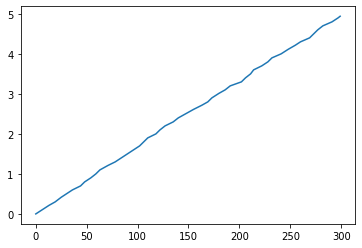

In [264]:
def gen_phase_traj(time, period_dist, t_cutoff, fs, num_events=1):
    # one period is divided into num_events independent stochastic events
    # generate periods
    periods = []
    while sum(periods) <= 2*t_cutoff:
        periods.append(period_dist.rvs()/num_events)
    periods = np.array(periods)
    # generate trajectory by appending lines for each period
    traj = np.array([0])
    for i, p in enumerate(periods):
        new_period = np.linspace(0, 1/num_events, int(p*fs))[1:] + i*(1/num_events)
        traj = np.append(traj, new_period)
    # crop trajectory
    traj = traj[:int(t_cutoff*fs)]
    return traj

period_dist = skewnorm(*skewnorm.fit(T)) # fit distribution
plt.plot(gen_phase_traj(t_interp, period_dist, 50, 6, num_events=10))

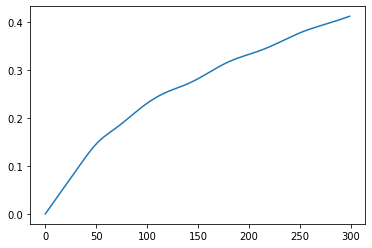

In [255]:
num = 10000
g_phases = np.zeros((num, int(t_cutoff*fs)))
period_dist = skewnorm(*skewnorm.fit(T)) # fit distribution

for i in range(num):
    new_traj = gen_phase_traj(t_interp, period_dist, 50, 6, num_events=1)
    g_phases[i,:] = new_traj

plt.plot(np.std(g_phases, axis=0))

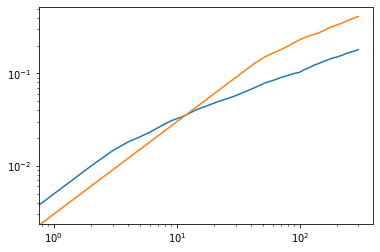

In [285]:
#g_phases2 = g_phases
plt.loglog(np.std(g_phases2, axis=0))
plt.loglog(np.std(g_phases, axis=0))

In [282]:
def gen_phase_traj_period_num(time, period_dist, t_cutoff, fs, num_events=1):
    # generate periods
    periods = []
    while sum(periods) <= 2*t_cutoff:
        periods.append(period_dist.rvs()/num_events)
    periods = np.array(periods)
    # generate trajectory by appending lines for each period
    traj = np.array([])
    for i, p in enumerate(periods):
        new_period = np.ones(int(p*fs))*(i+1)*(1/num_events)
        traj = np.append(traj, new_period)
    # crop trajectory
    traj = traj[:int(t_cutoff*fs)]
    return traj

num = 1000
period_num = np.zeros((num, int(t_cutoff*fs)))
period_dist = skewnorm(*skewnorm.fit(T)) # fit distribution

for i in range(num):
    new_traj = gen_phase_traj_period_num(t_interp, period_dist, 50, 6, num_events=3)
    period_num[i,:] = new_traj



Text(0, 0.5, 'average current period')

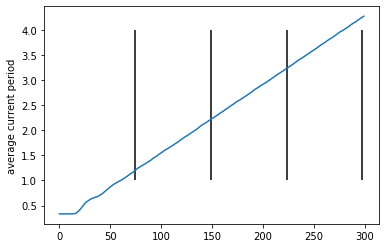

In [283]:
plt.plot(np.mean(period_num, axis=0))
mean_periods = [period_dist.mean()*fs, period_dist.mean()*fs*2, period_dist.mean()*fs*3, period_dist.mean()*fs*4]
plt.vlines(mean_periods, ymin=1, ymax=4)
plt.ylabel('average current period')

Text(0, 0.5, 'std of number of periods')

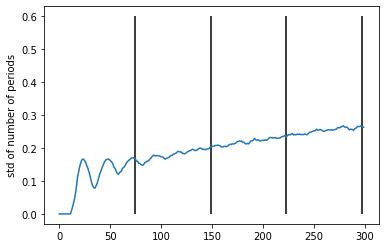

In [284]:
plt.plot(np.std(period_num, axis=0))
mean_periods = [period_dist.mean()*fs, period_dist.mean()*fs*2, period_dist.mean()*fs*3, period_dist.mean()*fs*4]
plt.vlines(mean_periods, ymin=0, ymax=0.6)
plt.ylabel('std of number of periods')

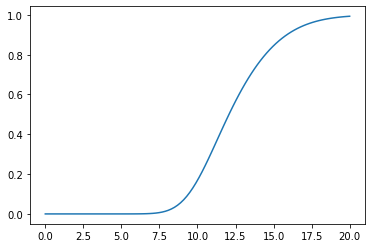

In [242]:
x = np.linspace(0,20, 100)
plt.plot(x, period_dist.cdf(x))

### Information theory

<ErrorbarContainer object of 3 artists>

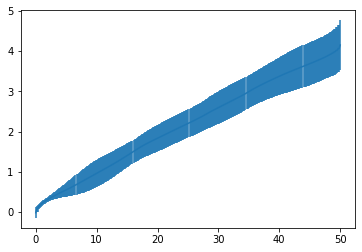

In [353]:
p_mean = np.mean(uphases, axis=0)/(2*np.pi)
p_std = np.std(uphases, axis=0)/(2*np.pi)
t_ = t_interp
d_p_mean = savgol_filter(np.diff(p_mean), 17, 1)
d_p_std = savgol_filter(np.diff(p_std), 17, 1)

plt.errorbar(t_[:], y=p_mean, yerr=p_std)

In [549]:
np.log2((p_mean.max() - p_mean.min())/p_std.mean())

3.5284852515533105

In [545]:
2**1.75

3.363585661014858

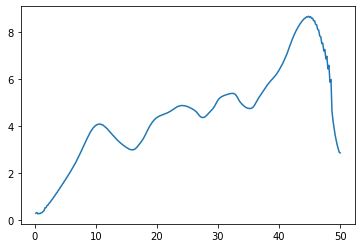

In [220]:
def fisher(mean, std, d_mean, d_std):
    #if len(mean) != len(d_mean):
        #raise ValueError('Check equal vector length')
    return (d_mean**2/std**2 + 2*d_std**2/std**2)

def cramer_rao(f):
    return np.sqrt(1/f)
# some scaling issue?

plt.plot(t_[1:], 1/np.sqrt(fisher(p_mean[1:], p_std[1:], d_p_mean, d_p_std))/fs)

In [230]:
t_here = 40*fs
1/np.sqrt(fisher(p_mean[t_here], p_std[t_here], d_p_mean[t_here], d_p_std[t_here]))/fs

6.455692990739987

In [223]:
p_mean[t_here]

2.6045606662332705

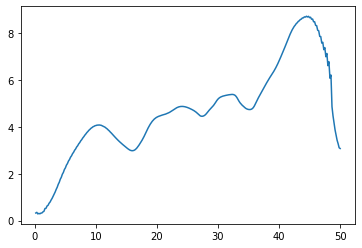

In [224]:
def error_prop(std, d_mean):
    return std/d_mean

plt.plot(t_[1:], error_prop(p_std[1:], d_p_mean)/6)

#### Entropy

In [87]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.stats import skewnorm
from scipy.stats import uniform

# Overview
- Main question: How to calculate mutual information?
- First try with real data (may not work in this notebook, copy to SI_figures.ipynb instead)
- Gaussian approximation
    - direct formula
    - entropy formula (nicer, can be explained a bit)
- Direct method
    - sample size extrapolation
    - binning extrapolation
- MI for different time periods (increasing/decreasing)
- Effect of: time binning, phase resolution... All leads to same value
- Problem: Tkacik 2015 Fig 1 estimations as bound for realistic MI values seem way off
- Now look at synthetic data: Linear increase (0 to 1) with defined noise (normal/uniform)
- Also try easy approx. formula (small sd)
- Step function with increasing number of steps (linear in limit) gives insight into disparity
- Estimations work only for uniform dist! 

In [538]:
# Define distributions

p_range = np.arange(-3, 38, 0.2) # 
fs_p=5
t_range = t_interp # fs=6
fs_t = 6
cond_grid = np.zeros((len(t_range), len(p_range)))

# fill grid with samples from fitted gaussian distribution 
#-> conditional probabilities P(phase|time)
for i in range(len(t_range)):
    cond_grid[i,:] = norm.pdf(p_range, *norm.fit(uphases[:,i]))/fs_p
    
marg_time = 1/len(t_range) # marginal probability, all time points equally likely
marg_phase = np.sum(cond_grid, axis=0)/len(t_range) # marginal prob for phase integrate cond_grid over time

\\[ I(t;\phi) = \sum_{t_i} P_t(t_i) \sum_{\phi_j} P(\phi_j | t_i) \log_2 \frac{P(\phi_j | t_i)}{P_{\phi}(\phi_j)} \\]

In [523]:
def log_term(cond, marg):
    out = np.log2(cond/marg)
    if np.isinf(out):
        return 0
    else:
        return out

I = 0
for i, t in enumerate(t_range):
    for j, p in enumerate(p_range):
        I += marg_time*cond_grid[i,j]*log_term(cond_grid[i,j], marg_phase[j])
print(f'Mutual Information: {I} bits')

Mutual Information: 1.7588986577115284 bits


C:\Users\e14user\Anaconda\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log2
  


\\[
I(t; \phi) = S[P_{\phi}(\phi)] - \langle  S [ P(\phi | t) ]  \rangle_t
\\]
\\[
S[p(x)] = - \sum_{x_i} p(x_i) \log_2 p(x_i)
\\]

In [485]:
def entropy(dist):
    S = 0
    for i, pi in enumerate(dist):
        if np.isinf(np.log2(pi)):
            pass
        else:
            S += -pi*np.log2(pi)
    return S

I = 0
# entropy from dynamic range
I += entropy(marg_phase)
# entropy of noise
for i, t in enumerate(t_range):
    I += -1*entropy(cond_grid[i,:])/len(t_range)
print(f'Mutual Information: {I} bits')

Mutual Information: 1.758898657711518 bits


C:\Users\e14user\Anaconda\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log2
  after removing the cwd from sys.path.


In [208]:
# now look at mutual information depending on time
I_range = []
#t_i_range = np.arange(0, 290, 10)
t_i_range = np.arange(10, 300, 10)
for t_i_end in t_i_range:
    t_range = t_interp[0:t_i_end] # fs=6
    cond_grid = np.zeros((len(t_range), len(p_range)))
    for i in range(len(t_range)):
        cond_grid[i,:] = norm.pdf(p_range, *norm.fit(uphases[:,i]))/fs_p

    marg_time = 1/len(t_range) # marginal probability, all time points equally likely
    marg_phase = np.sum(cond_grid, axis=0)/len(t_range) 

    I = 0
    for i, t in enumerate(t_range):
        for j, p in enumerate(p_range):
            I += marg_time*cond_grid[i,j]*log_term(cond_grid[i,j], marg_phase[j])
    I_range.append(I)
I_range = np.array(I_range)

C:\Users\e14user\Anaconda\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  
C:\Users\e14user\Anaconda\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log2
  


Text(0, 0.5, 'Mutual Information (bits)')

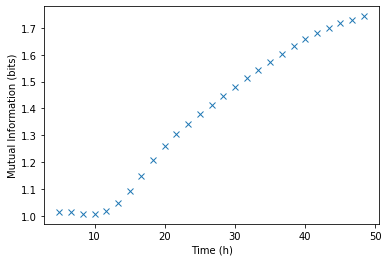

In [209]:
plt.plot(t_i_range/fs_t, I_range, 'x')
plt.xlabel('Time (h)')
plt.ylabel('Mutual Information (bits)')

In [206]:
# now look at mutual information depending on time
I_range = []
t_i_range = np.arange(0, 290, 10)
for t_i_start in t_i_range:
    t_range = t_interp[t_i_start:] # fs=6
    cond_grid = np.zeros((len(t_range), len(p_range)))
    for i, ti in enumerate(np.arange(t_i_start, 300)):
        cond_grid[i,:] = norm.pdf(p_range, *norm.fit(uphases[:,ti]))/fs_p

    marg_time = 1/len(t_range) # marginal probability, all time points equally likely
    marg_phase = np.sum(cond_grid, axis=0)/len(t_range) 

    I = 0
    for i, t in enumerate(t_range):
        for j, p in enumerate(p_range):
            I += marg_time*cond_grid[i,j]*log_term(cond_grid[i,j], marg_phase[j])
    I_range.append(I)
I_range = np.array(I_range)

C:\Users\e14user\Anaconda\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log2
  


Text(0, 0.5, 'Mutual Information (bits)')

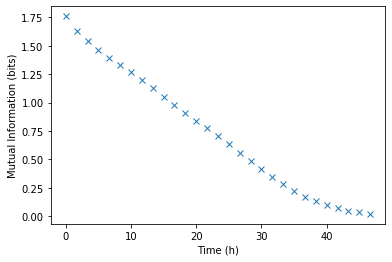

In [207]:
plt.plot(t_i_range/fs_t, I_range, 'x')
plt.xlabel('Time (h)')
plt.ylabel('Mutual Information (bits)')

(0.9496795535087585, 0.28818219900131226)

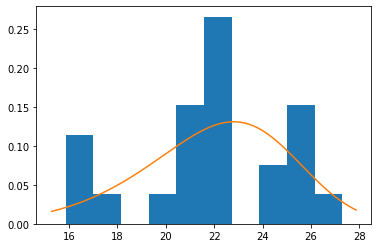

In [303]:
# check normality
i = 250
plt.hist(uphases[:,i], density=True)
x_lim = plt.xlim()
x_range = np.linspace(x_lim[0], x_lim[1], 1000)
plt.plot(x_range, skewnorm.pdf(x_range, *skewnorm.fit(uphases[:,i])))

from scipy.stats import shapiro
shapiro(uphases[:,i])

- conditional probability is not really normal
- unclear which distribution to take
- try different approach instead: bin data (don't approximate distribution)

C:\Users\e14user\Anaconda\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: Mean of empty slice.
  """


(array([0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.0826087 , 0.02753623, 0.05507246, 0.16521739, 0.11014493,
        0.0826087 , 0.0826087 , 0.02753623, 0.        ]),
 array([ 0.        ,  1.57894737,  3.15789474,  4.73684211,  6.31578947,
         7.89473684,  9.47368421, 11.05263158, 12.63157895, 14.21052632,
        15.78947368, 17.36842105, 18.94736842, 20.52631579, 22.10526316,
        23.68421053, 25.26315789, 26.84210526, 28.42105263, 30.        ]),
 <a list of 19 Patch objects>)

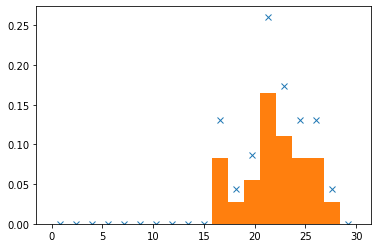

In [321]:
data = uphases[:,i]
b = 20
bins = np.linspace(0, 30, b)
digitized = np.digitize(data, bins)
bin_means = [data[digitized == i].mean() for i in range(1, len(bins))]
bin_count = np.array([len(data[digitized == i]) for i in range(1, len(bins))])/data.shape[0]
#plt.plot(data)
plt.plot((bins[1:]+bins[:-1])/2, bin_count, 'x')
plt.hist(uphases[:,i], bins=bins, density=True)


In [378]:
# Bin phase data and calculate conditional and marginal probabilities
b_range = np.arange(5,30,1)
I_b = []

for b in b_range:
    bins = np.linspace(0, 30, b)

    fs_p=b/30
    t_range = t_interp # fs=6
    fs_t = 6
    cond_grid = np.zeros((len(t_range), len(bins)-1))

    # fill grid with histogram from data with given bins
    #-> conditional probabilities P(phase|time)
    for i in range(len(t_range)):
        data = uphases[:,i]
        digitized = np.digitize(data, bins)
        cond_grid[i,:] = np.array([len(data[digitized == i]) for i in range(1, len(bins))])/len(data)

    marg_time = 1/len(t_range) # marginal probability, all time points equally likely
    marg_phase = np.sum(cond_grid, axis=0)/len(t_range) # marginal prob for phase integrate cond_grid over time

    I = 0
    for i, t in enumerate(t_range):
        for j in range(len(bins)-1):
            I += marg_time*cond_grid[i,j]*log_term(cond_grid[i,j], marg_phase[j])
    I_b.append(I)

C:\Users\e14user\Anaconda\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log2
  


Text(0, 0.5, 'I')

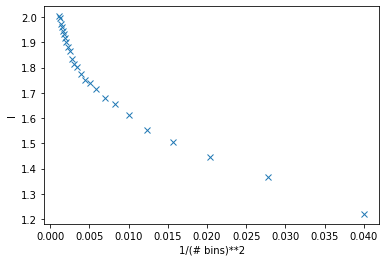

In [544]:
plt.plot(1/b_range**2, I_b, 'x')
plt.xlabel('1/(# bins)**2')
plt.ylabel('I')

- Effect of sample size should also be looked at
- Randomly pick N samples out of 23

In [408]:
N_range = np.arange(10,23,1)
I_N = []

for N in N_range:
    random_choice = np.random.choice(range(23), N, replace=False)
    uphases_random = uphases[random_choice, :]
    
    b=20
    bins = np.linspace(0, 30, b)

    fs_p=b/30
    t_range = t_interp # fs=6
    fs_t = 6
    cond_grid = np.zeros((len(t_range), len(bins)-1))

    # fill grid with histogram from data with given bins
    #-> conditional probabilities P(phase|time)
    for i in range(len(t_range)):
        data = uphases_random[:,i]
        digitized = np.digitize(data, bins)
        cond_grid[i,:] = np.array([len(data[digitized == i]) for i in range(1, len(bins))])/len(data)

    marg_time = 1/len(t_range) # marginal probability, all time points equally likely
    marg_phase = np.sum(cond_grid, axis=0)/len(t_range) # marginal prob for phase integrate cond_grid over time

    I = 0
    for i, t in enumerate(t_range):
        for j in range(len(bins)-1):
            I += marg_time*cond_grid[i,j]*log_term(cond_grid[i,j], marg_phase[j])
    I_N.append(I)

C:\Users\e14user\Anaconda\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log2
  


20 bins


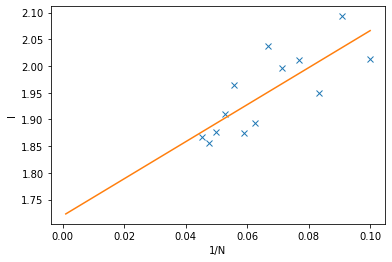

In [410]:
from scipy.optimize import curve_fit
def fitfunc(x, a, b):
    return (a/x + b)
popt, pcov = curve_fit(fitfunc, N_range, I_N)

plt.plot(1/N_range, I_N, 'x')
x_range = np.linspace(N_range.min(), 1000, 1000)
plt.plot(1/x_range, fitfunc(x_range, *popt))
plt.xlabel('1/N')
plt.ylabel('I')
print(f'{b} bins')

- Try effect of normalizing the base data
- bin time data?

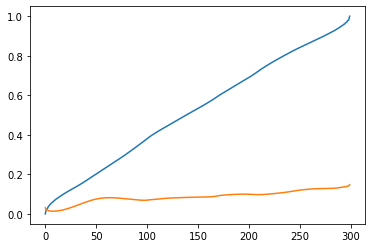

In [436]:
# normalize data
norm_phases = uphases.copy()
norm_phases = (norm_phases - np.min(np.mean(norm_phases, axis=0)))/(np.max(np.mean(norm_phases, axis=0)) - np.min(np.mean(norm_phases, axis=0)))
               
plt.plot(np.mean(norm_phases, axis=0))
plt.plot(np.std(norm_phases, axis=0))

In [444]:
print(f'minimum for p_range: {np.min(np.mean(norm_phases, axis=0) - 3*np.std(norm_phases, axis=0))}')
print(f'maximum for p_range: {np.max(np.mean(norm_phases, axis=0) + 3*np.std(norm_phases, axis=0))}')
print(f'step for p_range: {np.std(norm_phases, axis=0).min()/2}')

minimum for p_range: -0.09354300970048257
maximum for p_range: 1.443262020949598
step for p_range: 0.006727948991385945


In [476]:
p_step_range = np.arange(0.001, 0.05, 0.001)
I_p_step = []
for p_step in p_step_range:
    p_range = np.arange(-0.1, 1.45, p_step) # 
    fs_p=len(p_range)/(p_range.max() - p_range.min())
    t_range = t_interp # fs=6
    fs_t = 6
    cond_grid = np.zeros((len(t_range), len(p_range)))

    # fill grid with samples from fitted gaussian distribution 
    #-> conditional probabilities P(phase|time)
    for i in range(len(t_range)):
        cond_grid[i,:] = norm.pdf(p_range, *norm.fit(norm_phases[:,i]))/fs_p

    marg_time = 1/len(t_range) # marginal probability, all time points equally likely
    marg_phase = np.sum(cond_grid, axis=0)/len(t_range) # marginal prob for phase integrate cond_grid over time

    I = 0
    for i, t in enumerate(t_range):
        for j, p in enumerate(p_range):
            I += marg_time*cond_grid[i,j]*log_term(cond_grid[i,j], marg_phase[j])
    I_p_step.append(I)

C:\Users\e14user\Anaconda\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log2
  


Text(0, 0.5, 'I')

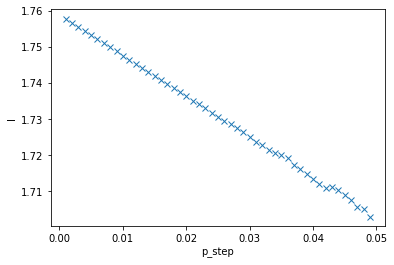

In [477]:
plt.plot(p_step_range, I_p_step, 'x')
plt.xlabel('p_step')
plt.ylabel('I')

Conclusions so far:
- Alternative method (no dists estimated, vary sample size and binning) works as well with extrapolation methods, but gives similar results, prob best to stick to simpler version
- (Value depends strongly on p_range step (start/stop only make small difference up to certain point). I proportional to 1/p_step)
- Nevermind, p_step makes little difference. Neither does norming the data
- t quantization wasn't touched so far

In [498]:
bin_factor_range = np.arange(1, 15, 1).astype(int)
I_bt = []
for bin_factor in bin_factor_range:
    t_binned_data = uphases[:,::bin_factor]
    t_binned_time = t_interp[::bin_factor]
    
    p_range = np.arange(-3, 38, 0.2) # 
    fs_p=5
    t_range = t_binned_time # fs=6
    fs_t = 6
    cond_grid = np.zeros((len(t_range), len(p_range)))

    # fill grid with samples from fitted gaussian distribution 
    #-> conditional probabilities P(phase|time)
    for i in range(len(t_range)):
        cond_grid[i,:] = norm.pdf(p_range, *norm.fit(t_binned_data[:,i]))/fs_p

    marg_time = 1/len(t_range) # marginal probability, all time points equally likely
    marg_phase = np.sum(cond_grid, axis=0)/len(t_range) # marginal prob for phase integrate cond_grid over time

    I = 0
    # entropy from dynamic range
    I += entropy(marg_phase)
    # entropy of noise
    for i, t in enumerate(t_range):
        I += -1*entropy(cond_grid[i,:])/len(t_range)
    I_bt.append(I)

C:\Users\e14user\Anaconda\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log2
  after removing the cwd from sys.path.


Text(0, 0.5, 'I')

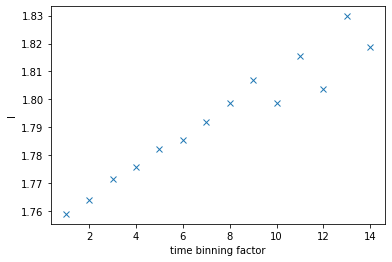

In [501]:
plt.plot(bin_factor_range, I_bt, 'x')
plt.xlabel('time binning factor')
plt.ylabel('I')

## Synthetic Data

In [174]:
sd_range = np.linspace(0.01, 0.5, 30)
I_sd = []
I_t_sd = []

for sd in sd_range:
    # create synthetic data

    num = 1000 # varying num has no effect
    t = np.linspace(0, 50, 300)
    y = np.linspace(1, 0, 300) + norm.rvs(0, 0.1, size=300) 
    # uncorrelated noise (size = 300) or constant noise (size = 1)´(seems to make no difference)
    data = np.zeros((num,300))
    for i in range(num):
        data[i,:] = np.linspace(0, 1, 300) + norm.rvs(0, sd, size=1)

    # Define distributions

    p_range = np.arange(-0.3, 1.3, 0.008) # 
    fs_p=len(p_range)/(p_range.max() - p_range.min())
    t_range = t # fs=6
    fs_t = 6
    cond_grid = np.zeros((len(t_range), len(p_range)))

    # fill grid with samples from fitted gaussian distribution 
    #-> conditional probabilities P(phase|time)
    for i in range(len(t_range)):
        cond_grid[i,:] = norm.pdf(p_range, *norm.fit(data[:,i]))/fs_p

    marg_time = 1/len(t_range) # marginal probability, all time points equally likely
    marg_phase = np.sum(cond_grid, axis=0)/len(t_range) # marginal prob for phase integrate cond_grid over time

    # calculate MI
    I = 0
    for i, t in enumerate(t_range):
        for j, p in enumerate(p_range):
            I += marg_time*cond_grid[i,j]*log_term(cond_grid[i,j], marg_phase[j])
    I_sd.append(I)
    
    # theoretical MI
    I_t = np.log2((np.mean(data, axis=0).max() - np.mean(data, axis=0).min())/np.std(data, axis=0).mean())
    I_t_sd.append(I_t)
    #print(f'Mutual Information: {I} bits, theory: {I_t} bits')

I_sd = np.array(I_sd)
I_t_sd = np.array(I_t_sd)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log2
  


Text(0, 0.5, 'I')

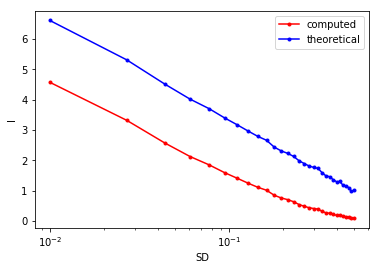

In [175]:
plt.semilogx(sd_range, I_sd, 'r.-', label='computed')
plt.plot(sd_range, I_t_sd, 'b.-', label='theoretical')
plt.legend()
plt.xlabel('SD')
plt.ylabel('I')

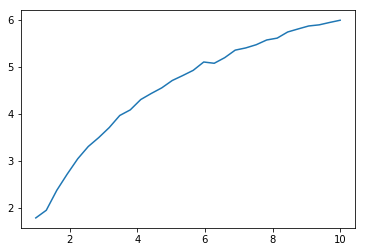

In [173]:
plt.plot(sd_range, I_t_sd-I_sd)

In [348]:
# gaussian approx method
# create synthetic data

sd = 0.05
num = 1000 # varying num has no effect
t = np.linspace(0, 50, 300)
y = np.linspace(1, 0, 300) + norm.rvs(0, 0.1, size=300) 
# uncorrelated noise (size = 300) or constant noise (size = 1)´(seems to make no difference)
data = np.zeros((num,300))
for i in range(num):
    data[i,:] = np.linspace(0, 1, 300) + norm.rvs(0, sd, size=1)

# Define distributions

p_range = np.arange(-0.3, 1.3, 0.008) # 
fs_p=len(p_range)/(p_range.max() - p_range.min())
t_range = t # fs=6
fs_t = 6
cond_grid = np.zeros((len(t_range), len(p_range)))

# fill grid with samples from fitted gaussian distribution 
#-> conditional probabilities P(phase|time)
for i in range(len(t_range)):
    cond_grid[i,:] = norm.pdf(p_range, *norm.fit(data[:,i]))/fs_p

marg_time = 1/len(t_range) # marginal probability, all time points equally likely
marg_phase = np.sum(cond_grid, axis=0)/len(t_range) # marginal prob for phase integrate cond_grid over time

# calculate MI
I = 0
for i, t in enumerate(t_range):
    for j, p in enumerate(p_range):
        I += marg_time*cond_grid[i,j]*log_term(cond_grid[i,j], marg_phase[j])

# theoretical MI
I_t = np.log2((np.mean(data, axis=0).max() - np.mean(data, axis=0).min())/np.std(data, axis=0).mean())
#I_t = np.log2(1/sd) # for uniform

print(f'Mutual Information: {I} bits, theory: {I_t} bits')

Mutual Information: 2.4195066203147815 bits, theory: 4.346271650397299 bits


In [337]:
# Approx formula, depending on sd_t, only for small sd_phase
def MI_approx(sigma, L):
    out = 0
    for i in range(len(sigma)):
        term = np.log2(L/np.sqrt(2*np.pi*np.e*sigma[i]**2))
        if np.isinf(out):
            term = 0
        out += term
    return out/len(sigma)

def sigma_t(mean_phase, sd_phase, fs):
    return sd_phase[1:]/(np.diff(mean_phase)*fs)


sigma = sigma_t(np.mean(data, axis=0), np.std(data, axis=0), 1)
MI_approx(sigma, 300)

2.2319445813328698

In [234]:
# direct calculation

# create synthetic data

sd = 0.2
num = 1000 # varying num has no effect
t = np.linspace(0, 50, 300)
y = np.linspace(1, 0, 300) + norm.rvs(0, 0.1, size=300) 
# uncorrelated noise (size = 300) or constant noise (size = 1)´(seems to make no difference)
data = np.zeros((num,300))
for i in range(num):
    data[i,:] = np.linspace(0, 1, 300) + norm.rvs(0, sd, size=1)

    
# Bin phase data and calculate conditional and marginal probabilities

b_range = np.arange(5,30,2)
I_b = []

for b in b_range:
    bins = np.linspace(-0.3, 1.3, b)

    fs_p=b/30
    t = np.linspace(0, 50, 300)
    t_range = t # fs=6
    fs_t = 6
    cond_grid = np.zeros((len(t_range), len(bins)-1))

    # fill grid with histogram from data with given bins
    #-> conditional probabilities P(phase|time)
    for i in range(len(t_range)):
        data_i = data[:,i]
        digitized = np.digitize(data_i, bins)
        cond_grid[i,:] = np.array([len(data_i[digitized == i]) for i in range(1, len(bins))])/len(data_i)

    marg_time = 1/len(t_range) # marginal probability, all time points equally likely
    marg_phase = np.sum(cond_grid, axis=0)/len(t_range) # marginal prob for phase integrate cond_grid over time

    I = 0
    for i, t in enumerate(t_range):
        for j in range(len(bins)-1):
            I += marg_time*cond_grid[i,j]*log_term(cond_grid[i,j], marg_phase[j])
    I_b.append(I)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log2
  


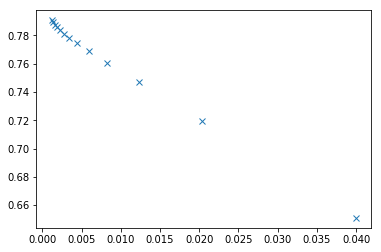

In [197]:
plt.plot(1/b_range**2, I_b, 'x')

In [200]:
I_t = np.log2((np.mean(data, axis=0).max() - np.mean(data, axis=0).min())/np.std(data, axis=0).mean())
I_t

2.3307108681163293

(array([  1.,   8.,  26.,  97., 193., 252., 235., 137.,  36.,  15.]),
 array([0.22803398, 0.36158053, 0.49512709, 0.62867364, 0.7622202 ,
        0.89576675, 1.02931331, 1.16285986, 1.29640642, 1.42995298,
        1.56349953]),
 <a list of 10 Patch objects>)

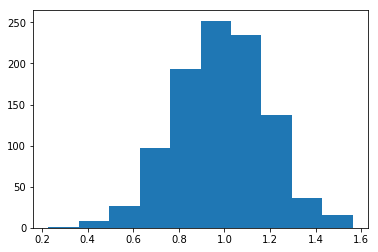

In [206]:
plt.hist(data[:,299])

- Conclusion: 1-2bit difference between computed and theoretical value for linear function with constant sd
- Try 2 state situation (or more), step function
- Try osc from period distribution

In [221]:
# step function

sd = 0.05
num = 1000 # varying num has no effect
t = np.linspace(0, 50, 300)
y = np.append(np.ones(150), np.zeros(150)) + norm.rvs(0, 0.1, size=300) 
# uncorrelated noise (size = 300) or constant noise (size = 1)´(seems to make no difference)
data = np.zeros((num,300))
for i in range(num):
    data[i,:] = np.append(np.ones(150), np.zeros(150)) + norm.rvs(0, sd, size=1)

# Define distributions

p_range = np.arange(-0.3, 1.3, 0.008) # 
fs_p=len(p_range)/(p_range.max() - p_range.min())
t_range = t # fs=6
fs_t = 6
cond_grid = np.zeros((len(t_range), len(p_range)))

# fill grid with samples from fitted gaussian distribution 
#-> conditional probabilities P(phase|time)
for i in range(len(t_range)):
    cond_grid[i,:] = norm.pdf(p_range, *norm.fit(data[:,i]))/fs_p

marg_time = 1/len(t_range) # marginal probability, all time points equally likely
marg_phase = np.sum(cond_grid, axis=0)/len(t_range) # marginal prob for phase integrate cond_grid over time

# calculate MI
I = 0
for i, t in enumerate(t_range):
    for j, p in enumerate(p_range):
        I += marg_time*cond_grid[i,j]*log_term(cond_grid[i,j], marg_phase[j])

print(f'Mutual Information: {I} bits, theory: 1 bits')

Mutual Information: 0.994999998714039 bits, theory: 1 bits


In [233]:
# 4 step function

sd = 0.05
num = 1000 # varying num has no effect
t = np.linspace(0, 50, 300)
y = np.append(np.ones(150), np.zeros(150)) + norm.rvs(0, 0.1, size=300) 
# uncorrelated noise (size = 300) or constant noise (size = 1)´(seems to make no difference)
data = np.zeros((num,300))
for i in range(num):
    data[i,:] = np.concatenate((np.ones(75), 0.66*np.ones(75), 0.33*np.ones(75), np.zeros(75))) + norm.rvs(0, sd, size=1)

# Define distributions

p_range = np.arange(-0.3, 1.3, 0.008) # 
fs_p=len(p_range)/(p_range.max() - p_range.min())
t_range = t # fs=6
fs_t = 6
cond_grid = np.zeros((len(t_range), len(p_range)))

# fill grid with samples from fitted gaussian distribution 
#-> conditional probabilities P(phase|time)
for i in range(len(t_range)):
    cond_grid[i,:] = norm.pdf(p_range, *norm.fit(data[:,i]))/fs_p

marg_time = 1/len(t_range) # marginal probability, all time points equally likely
marg_phase = np.sum(cond_grid, axis=0)/len(t_range) # marginal prob for phase integrate cond_grid over time

# calculate MI
I = 0
for i, t in enumerate(t_range):
    for j, p in enumerate(p_range):
        I += marg_time*cond_grid[i,j]*log_term(cond_grid[i,j], marg_phase[j])

print(f'Mutual Information: {I} bits, theory: 2 bits')

Mutual Information: 1.987448300684042 bits, theory: 2 bits


For step function with very small sd, computed value is as expected

In [261]:
# create synthetic data, uniform dist instead of sd

sd = 0.2
num = 1000 # varying num has no effect
t = np.linspace(0, 50, 300)
y = np.linspace(1, 0, 300) + norm.rvs(0, 0.1, size=300) 
# uncorrelated noise (size = 300) or constant noise (size = 1)´(seems to make no difference)
data = np.zeros((num,300))
for i in range(num):
    data[i,:] = np.linspace(0, 1, 300) + uniform.rvs(0, sd, size=300)

# Define distributions

p_range = np.arange(-0.3, 1.3, 0.008) # 
fs_p=len(p_range)/(p_range.max() - p_range.min())
t_range = t # fs=6
fs_t = 6
cond_grid = np.zeros((len(t_range), len(p_range)))

# fill grid with samples from fitted gaussian distribution 
#-> conditional probabilities P(phase|time)
for i in range(len(t_range)):
    cond_grid[i,:] = norm.pdf(p_range, *norm.fit(data[:,i]))/fs_p

marg_time = 1/len(t_range) # marginal probability, all time points equally likely
marg_phase = np.sum(cond_grid, axis=0)/len(t_range) # marginal prob for phase integrate cond_grid over time

# calculate MI
I = 0
for i, t in enumerate(t_range):
    for j, p in enumerate(p_range):
        I += marg_time*cond_grid[i,j]*log_term(cond_grid[i,j], marg_phase[j])

# theoretical MI
I_t = np.log2((np.mean(data, axis=0).max() - np.mean(data, axis=0).min())/np.std(data, axis=0).mean())

print(f'Mutual Information: {I} bits, theory: {I_t} bits')

Mutual Information: 2.2125133837522286 bits, theory: 4.1186800592850945 bits


In [349]:
# N step function
step_range = np.arange(2, 30, 2)
I_step = []

for steps in step_range:
    sd = 0.1
    num = 1000 # varying num has no effect
    t = np.linspace(0, 50, 300)
    step_length = 300//steps
    y = np.ones((300-steps*step_length+step_length))
    for fac in np.linspace(1, 0, steps)[1:]:
        y = np.concatenate((y, fac*np.ones(step_length)))
    # uncorrelated noise (size = 300) or constant noise (size = 1)´(seems to make no difference)
    data = np.zeros((num,300))
    for i in range(num):
        data[i,:] = y + uniform.rvs(0, sd, size=1)

    # Define distributions

    p_range = np.arange(-0.3, 1.3, 0.008) # 
    fs_p=len(p_range)/(p_range.max() - p_range.min())
    t_range = t # fs=6
    fs_t = 6
    cond_grid = np.zeros((len(t_range), len(p_range)))

    # fill grid with samples from fitted gaussian distribution 
    #-> conditional probabilities P(phase|time)
    for i in range(len(t_range)):
        cond_grid[i,:] = norm.pdf(p_range, *norm.fit(data[:,i]))/fs_p

    marg_time = 1/len(t_range) # marginal probability, all time points equally likely
    marg_phase = np.sum(cond_grid, axis=0)/len(t_range) # marginal prob for phase integrate cond_grid over time

    # calculate MI
    I = 0
    for i, t in enumerate(t_range):
        for j, p in enumerate(p_range):
            I += marg_time*cond_grid[i,j]*log_term(cond_grid[i,j], marg_phase[j])
    I_step.append(I)


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log2
  


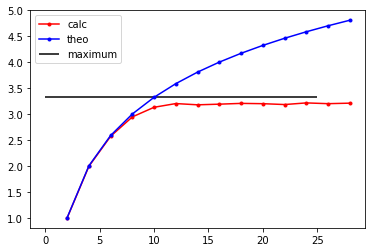

In [351]:
plt.plot(step_range, I_step, 'r.-', label='calc')
plt.plot(step_range, np.log2(step_range), 'b.-', label='theo')
plt.hlines(np.log2(1/sd), 0, 25, label='maximum')
plt.legend()

Linear function as limit of N step function:
- theo and calc values agree for low steps (theo here: log2(number_of_steps))
- at some point, dependent on sd, extra steps dont give extra information (calc)
- calc and theo diverge
- easier to understand with unifrom dist: As soon as as step height (1/steps) is same as range/sd, extra steps give no extra information!

## The solution:
- np.log2(1/sigma) formula is correct, but only for uniform dist!! For normal dist, the error is smeared out, hence less information
- now high confidence in calculation method

Other points:
- maybe try approx formula I = log2(C/sigma_t) -> Same as computed value, not theory! (only small sd)

# Conclusion
- keep calculated value
- compare with Information synth oscillator data from period distribution (also consider this for t-sd shape)
- read review for text
- for methods: compare SGA with DIR method (scatter plot on y=x line), SGA sample size extrapolation/DIR sample size and binning extrapolation

## Information in one period
- compare clock signal synchronous circuit

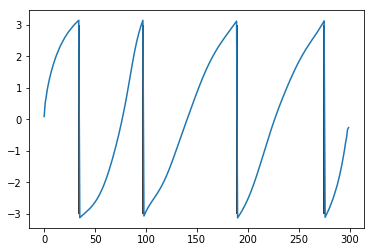

In [3]:
# format data

# find 2pi jump in phase trace

plt.plot(phases[10])
dp = np.diff(phases[10])
periods = np.where(dp<-6)[0]
plt.vlines(periods, -3, 3)

In [32]:
complete_periods = []
for i in range(phases.shape[0]):
    dp = np.diff(phases[i])
    periods = np.where(dp<-6)[0]
    prev = periods[0] + 1
    for p in periods[1:]:
        if (p+1-prev) > 10: # catch outlier
            complete_periods.append(phases[i][prev:p+1])
        prev = p + 1

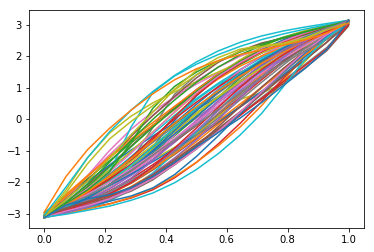

In [29]:
from scipy.interpolate import interp1d
N = 15
sampling = np.linspace(0,1,N)

for j in range(len(complete_periods)):
    t = np.linspace(0,1,len(complete_periods[j]))
    interp_func = interp1d(t, complete_periods[j], fill_value='extrapolate', kind='cubic')
    plt.plot(sampling, interp_func(sampling))

period_arr = np.zeros((len(complete_periods), N))
for j in range(len(complete_periods)):
    t = np.linspace(0,1,len(complete_periods[j]))
    interp_func = interp1d(t, complete_periods[j], fill_value='extrapolate', kind='cubic')
    period_arr[j] = interp_func(sampling)


In [6]:
period_arr_100 = period_arr.copy()

In [33]:
len(complete_periods)

72

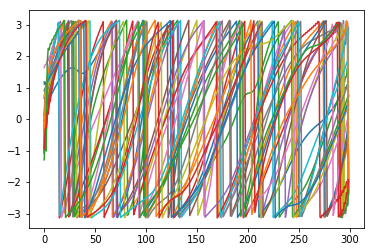

In [35]:
for i in range(phases.shape[0]):
    plt.plot(phases[i])

<ErrorbarContainer object of 3 artists>

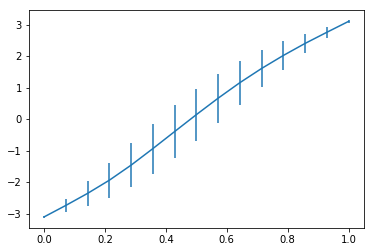

In [7]:
plt.errorbar(x = sampling, y = np.mean(period_arr, axis=0), yerr = np.std(period_arr, axis=0))

<ErrorbarContainer object of 3 artists>

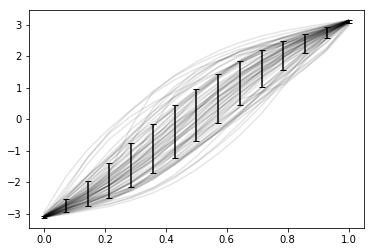

In [30]:

for i in range(period_arr.shape[0]):
    plt.plot(sampling, period_arr[i], 'k', alpha=0.1)
plt.errorbar(x = sampling, y = np.mean(period_arr, axis=0), yerr = np.std(period_arr, axis=0), fmt='none', ecolor='k', capsize=3)

In [110]:
# Define distributions

p_range = np.arange(-3.2, 3.2, 0.1) # 
fs_p=len(p_range)/(p_range.max() - p_range.min())
t_range = sampling 
fs_t = len(t_range)
cond_grid = np.zeros((len(t_range), len(p_range)))

# fill grid with samples from fitted gaussian distribution 
#-> conditional probabilities P(phase|time)
for i in range(len(t_range)):
    cond_grid[i,:] = norm.pdf(p_range, *norm.fit(period_arr[:,i]))/fs_p
    
marg_time = 1/len(t_range) # marginal probability, all time points equally likely
marg_phase = np.sum(cond_grid, axis=0)/len(t_range) # marginal prob for phase integrate cond_grid over time

\\[ I(t;\phi) = \sum_{t_i} P_t(t_i) \sum_{\phi_j} P(\phi_j | t_i) \log_2 \frac{P(\phi_j | t_i)}{P_{\phi}(\phi_j)} \\]

In [111]:
def log_term(cond, marg):
    out = np.log2(cond/marg)
    if np.isinf(out):
        return 0
    else:
        return out

I = 0
for i, t in enumerate(t_range):
    for j, p in enumerate(p_range):
        I += marg_time*cond_grid[i,j]*log_term(cond_grid[i,j], marg_phase[j])
print(f'Mutual Information: {I} bits')

Mutual Information: 2.014076796123059 bits


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log2
  


In [112]:
2**I

4.039220196459813

Try with FI instead of phase signal instead

In [145]:
complete_periods = []
for j, i in enumerate(selection):
    name, t, sig = load_data(i, df)
    t_interp, s_interp, i_cutoff = sig_interp(sig, t, t_cutoff, fs)
    s_smooth = savgol_filter(s_interp, 31, 3)
    peaks_i, T_i = peak_locations(s_smooth, 6)

    for i in range(len(peaks_i)-1):
        if (peaks_i[i+1]-peaks_i[i]) > 2:
            complete_periods.append(s_smooth[int(peaks_i[i]*fs):int(peaks_i[i+1]*fs)])


C:\ProgramData\Anaconda3\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


<ErrorbarContainer object of 3 artists>

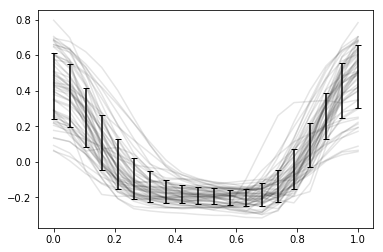

In [153]:
N = 20
sampling = np.linspace(0,1,N)

period_arr = np.zeros((len(complete_periods), N))
for j in range(len(complete_periods)):
    t = np.linspace(0,1,len(complete_periods[j]))
    interp_func = interp1d(t, complete_periods[j], fill_value='extrapolate', kind='cubic')
    period_arr[j] = interp_func(sampling)

for i in range(period_arr.shape[0]):
    plt.plot(sampling, period_arr[i], 'k', alpha=0.1)
plt.errorbar(x = sampling, y = np.mean(period_arr, axis=0), yerr = np.std(period_arr, axis=0), fmt='none', ecolor='k', capsize=3)

In [154]:
# Define distributions

p_range = np.arange(-3.2, 3.2, 0.1) # 
fs_p=len(p_range)/(p_range.max() - p_range.min())
t_range = sampling 
fs_t = len(t_range)
cond_grid = np.zeros((len(t_range), len(p_range)))

# fill grid with samples from fitted gaussian distribution 
#-> conditional probabilities P(phase|time)
for i in range(len(t_range)):
    cond_grid[i,:] = norm.pdf(p_range, *norm.fit(period_arr[:,i]))/fs_p
    
marg_time = 1/len(t_range) # marginal probability, all time points equally likely
marg_phase = np.sum(cond_grid, axis=0)/len(t_range) # marginal prob for phase integrate cond_grid over time

I = 0
for i, t in enumerate(t_range):
    for j, p in enumerate(p_range):
        I += marg_time*cond_grid[i,j]*log_term(cond_grid[i,j], marg_phase[j])
print(f'Mutual Information: {I} bits')

Mutual Information: 1.0732328043723982 bits


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log2
  


- Use Phase not FI
- make figure

<ErrorbarContainer object of 3 artists>

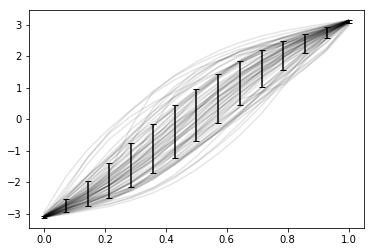

In [9]:
for i in range(period_arr.shape[0]):
    plt.plot(sampling, period_arr[i], 'k', alpha=0.1)
plt.errorbar(x = sampling, y = np.mean(period_arr, axis=0), yerr = np.std(period_arr, axis=0), fmt='none', ecolor='k', capsize=3)

(array([ 3.,  5.,  6.,  9., 11., 10., 10.,  7.,  8.,  3.]),
 array([0.25077663, 0.29528519, 0.33979374, 0.3843023 , 0.42881085,
        0.47331941, 0.51782797, 0.56233652, 0.60684508, 0.65135363,
        0.69586219]),
 <a list of 10 Patch objects>)

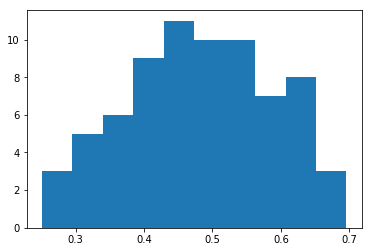

In [24]:
# cond. prob. dist.
# what time does the curve hit a given value phi* -> invert interpolation function

cond = []
phase_ = 0
for i in range(period_arr.shape[0]):
    cond.append(np.interp(phase_, period_arr[i], sampling))
cond = np.array(cond)
plt.hist(cond)

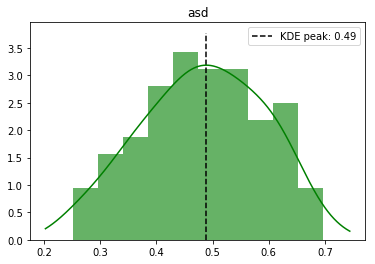

In [25]:
hist_kde(cond, 'asd')

# Dataset 3
- seperate oscillating/non oscillating cells, then analyze non oscillating fraction

5.526315789473685


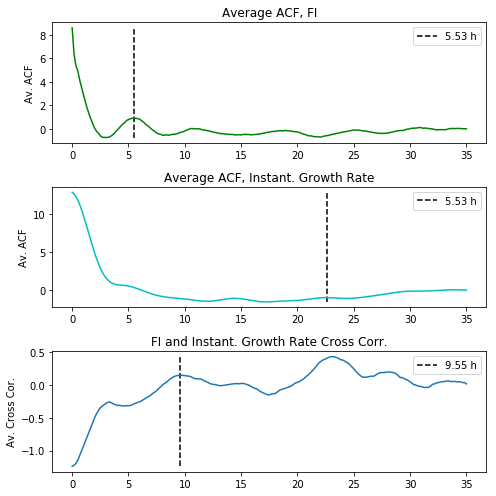

In [38]:
plt.figure(figsize=(7, 7))

plt.subplot(311)
plt.plot(t_interp, autocorr_avg, 'g-')
#plt.plot(t_interp, autocorr_growth_avg, label=f'growth, N = {len(selection)}')
#T_max = 1/freq_from_autocorr(autocorr_avg, 6)
T_max = t_interp[int(autocorr_first_peak(autocorr_avg[:150]))]
print(T_max)
plt.vlines(T_max, ymin=np.min(autocorr_avg), ymax=np.max(autocorr_avg), label=f'{T_max:.2f} h', linestyles='dashed')
plt.ylabel('Av. ACF')
plt.title('Average ACF, FI')
plt.legend()
plt.tight_layout()

plt.subplot(312)
plt.plot(t_g_interp, autocorr_growth_avg, 'c-')
T_max_g = t_g_interp[int(autocorr_first_peak(autocorr_growth_avg[:150]))]
plt.vlines(T_max_g, ymin=np.min(autocorr_growth_avg), ymax=np.max(autocorr_growth_avg), label=f'{T_max:.2f} h', linestyles='dashed')
plt.ylabel('Av. ACF')
plt.title('Average ACF, Instant. Growth Rate')
plt.legend()

plt.subplot(313)
plt.ylabel('Av. Cross Cor.')
plt.title(f'FI and Instant. Growth Rate Cross Corr.')
plt.plot(t_interp, crosscorr_avg)
T_max = t_interp[int(autocorr_first_peak(crosscorr_avg[:100]))]
plt.vlines(T_max, ymin=np.min(crosscorr_avg), ymax=np.max(crosscorr_avg), label=f'{T_max:.2f} h', linestyles='dashed')
plt.legend()


plt.tight_layout()


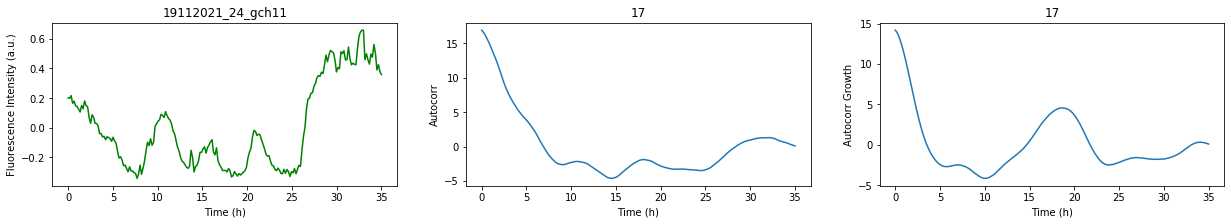

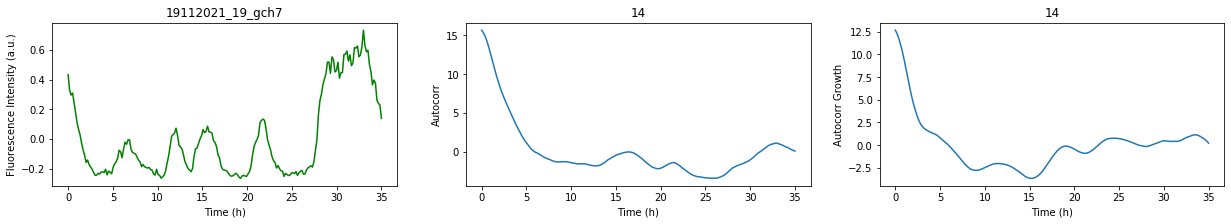

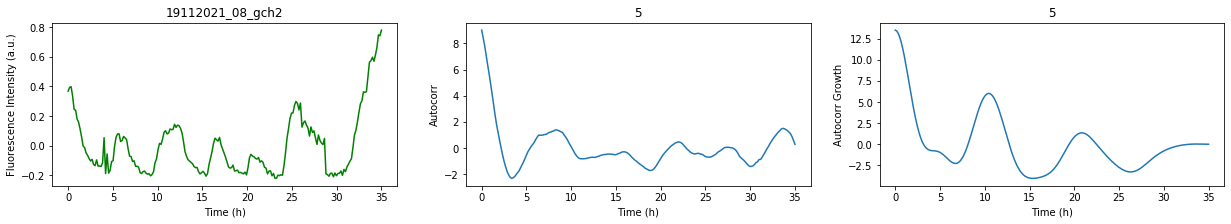

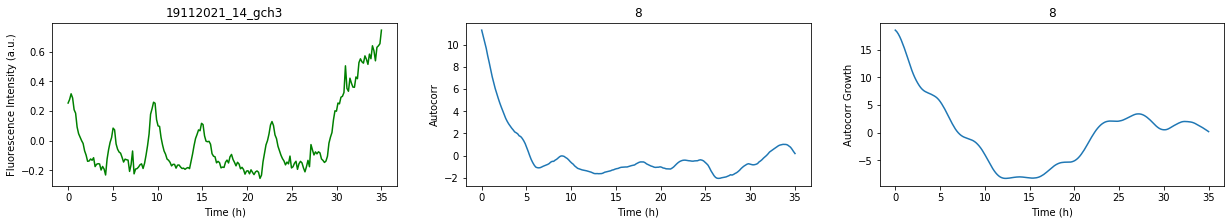

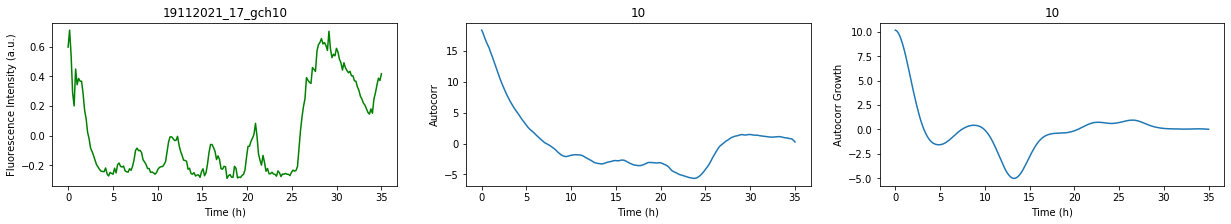

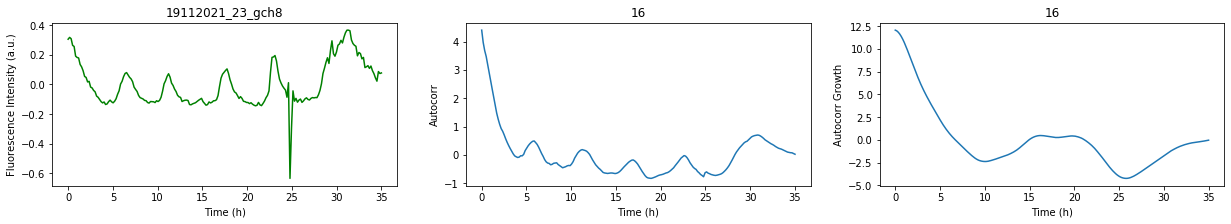

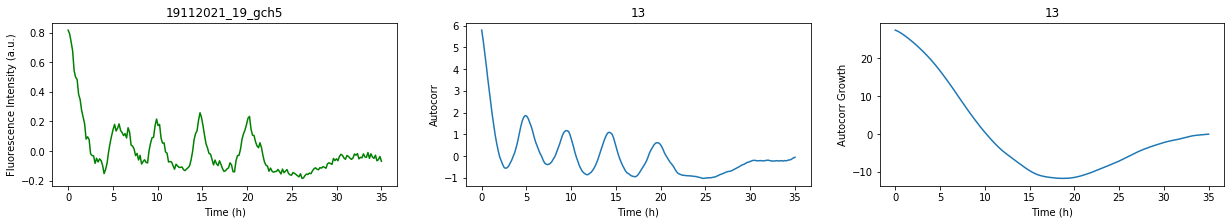

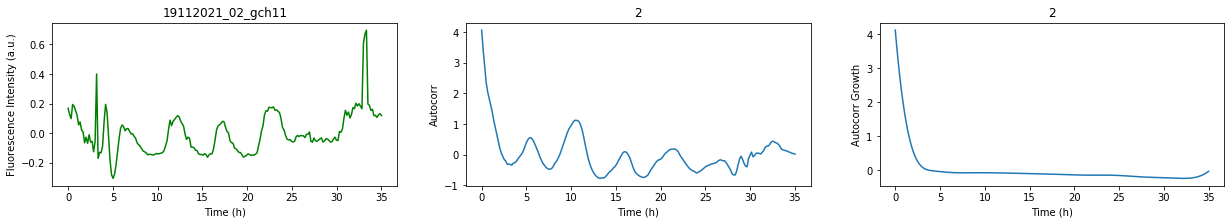

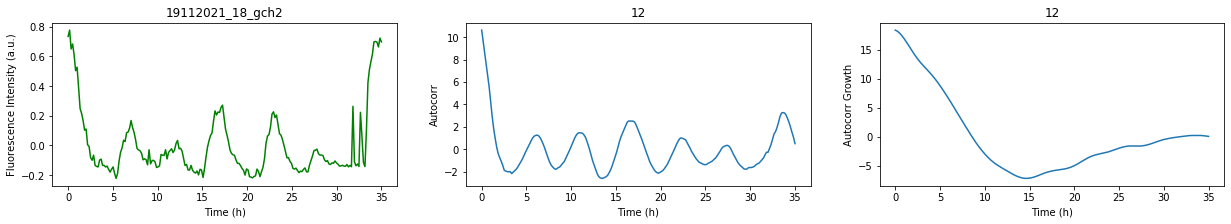

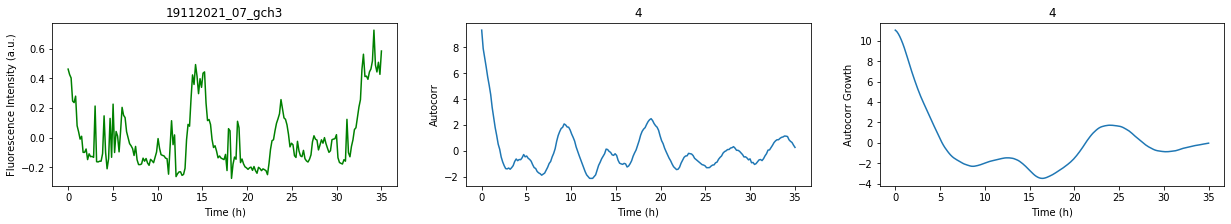

In [4]:
for i in np.random.choice(selection, 10, replace=False):
#for i in [44, 60]:
    name, t, sig = load_data(i, df)
    t_interp, s_interp, i_cutoff = sig_interp(sig, t, t_cutoff, fs)
    
    # calculate growth rate
    name, t, t2, area, area2, switch = load_area(i, df)
    div = div_events(t, area)
    div2 = div_events(t2, area2)
    g_rate = growth_rate(t, div, 6)
    g_rate2 = growth_rate(t2, div2, 6)
    cond = (not switch is None) & (not np.isnan(switch))
    autocorr_growth_sum = np.zeros(fs*t_cutoff)
    if cond:
        g_rate_switch = np.concatenate([g_rate[:int(switch)], g_rate2[int(switch):]])
        t_switch = np.concatenate([t[:int(switch)], t2[int(switch):-1]])
    else: 
        g_rate_switch = g_rate
        t_switch = t[:-1]
    t_g_interp, g_interp, i_cutoff = sig_interp(g_rate_switch, t_switch, t_cutoff, fs)
    autocorr_growth_sum += autocorr(g_interp)
    
    
    plt.figure(figsize=(21, 3))
    plt.subplot(131)
    plt.plot(t_interp, s_interp, 'g')
    plt.xlabel('Time (h)')
    plt.ylabel('Fluorescence Intensity (a.u.)')
    plt.title(name)

    plt.subplot(132)
    plt.plot(t_interp, autocorr(s_interp))
    plt.title(i)
    plt.xlabel('Time (h)')
    plt.ylabel('Autocorr')
    
    plt.subplot(133)
    plt.plot(t_interp, autocorr(g_interp))
    plt.title(i)
    plt.xlabel('Time (h)')
    plt.ylabel('Autocorr Growth')

Text(0, 0.5, 'Autocorr')

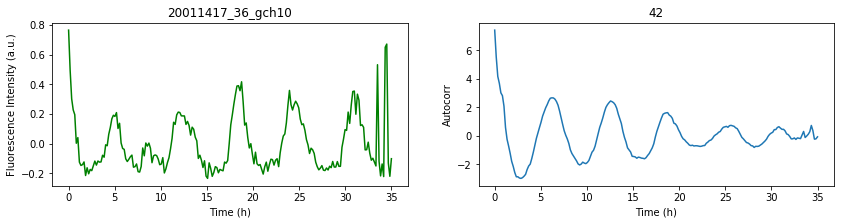

In [46]:
name, t, sig = load_data(60, df)
t_interp, s_interp, i_cutoff = sig_interp(sig, t, t_cutoff, fs)
plt.figure(figsize=(14, 3))
plt.subplot(121)
plt.plot(t_interp, s_interp, 'g')
plt.xlabel('Time (h)')
plt.ylabel('Fluorescence Intensity (a.u.)')
plt.title(name)

plt.subplot(122)
plt.plot(t_interp, autocorr(s_interp))
plt.title(i)
plt.xlabel('Time (h)')
plt.ylabel('Autocorr')

## Correlation sanity


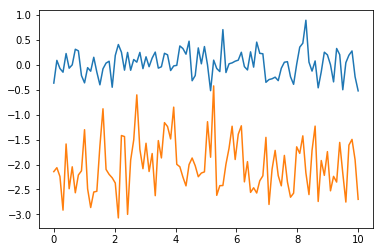

In [17]:

t = np.linspace(0,10, 100)
#sig1 = np.sin((5 + np.random.normal(0, 0.3, len(t)))*t) + np.random.normal(0, 0.3, len(t))
#sig2 = np.sin(0.5*t + 1) + np.random.normal(0, 0.3, len(t))
sig1 = np.random.normal(0, 0.3, len(t))
sig2 = np.random.normal(0, 0.5, len(t)) - 2

plt.plot(t, sig1)
plt.plot(t, sig2)

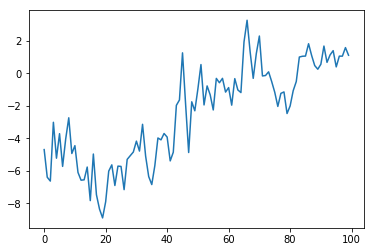

In [18]:
plt.plot(crosscorr(sig1, sig2))

### Give Error for peak location

In [62]:
### adapted from: https://gist.github.com/endolith/255291
def parabolic(f, x):
    """Quadratic interpolation for estimating the true position of an
    inter-sample maximum when nearby samples are known.
    f is a vector and x is an index for that vector.
    Returns (vx, vy), the coordinates of the vertex of a parabola that goes
    through point x and its two neighbors.
    Example:
    Defining a vector f with a local maximum at index 3 (= 6), find local
    maximum if points 2, 3, and 4 actually defined a parabola.
    In [3]: f = [2, 3, 1, 6, 4, 2, 3, 1]
    In [4]: parabolic(f, argmax(f))
    Out[4]: (3.2142857142857144, 6.1607142857142856)
    """
    xv = 1/2. * (f[x-1] - f[x+1]) / (f[x-1] - 2 * f[x] + f[x+1]) + x
    yv = f[x] - 1/4. * (f[x-1] - f[x+1]) * (xv - x)
    return (xv, yv)

def peak_fit(f, x, window=5):
    # initial estimate
    
    
    def fitfunc(x, a, b, c):
        return (a*(x - b)**2 + c)
    p0 = [-1, x, f[x]]
    fit_interval = np.arange(x - window//2, x+window//2+1, 1).astype(int)
    popt, pcov = curve_fit(fitfunc, fit_interval, f[fit_interval], p0=p0)
    
    return (popt[1], np.sqrt(np.diag(pcov))[1])


In [60]:
f = np.array([2, 3, 1, 4, 7, 5, 2, 3, 1])
b, berr, popt = peak_fit(f, np.argmax(f), window=5)

12.54180602006689


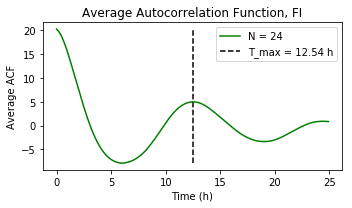

In [194]:
selection = df['id'].unique()
fs = 6
t_cutoff = 50

autocorr_sum = np.zeros(fs*t_cutoff)
for j, i in enumerate(selection):
    # try acf
    name, t, sig = load_data(i, df)
    t_interp, s_interp, i_cutoff = sig_interp(sig, t, t_cutoff, fs)
    autocorr_sum += autocorr(s_interp)
    
autocorr_avg = autocorr_sum/len(selection)

plt.figure(figsize=(5, 3))
plt.plot(t_interp[:150], autocorr_avg[:150], 'g-', label=f'N = {len(selection)}')
#plt.plot(t_interp, autocorr_growth_avg, label=f'growth, N = {len(selection)}')
#T_max = 1/freq_from_autocorr(autocorr_avg, 6)
T_max = t_interp[int(autocorr_first_peak(autocorr_avg[:150]))]
print(T_max)
plt.vlines(T_max, ymin=np.min(autocorr_avg), ymax=np.max(autocorr_avg), label=f'T_max = {T_max:.2f} h', linestyles='dashed')
plt.ylabel('Average ACF')
plt.xlabel('Time (h)')
plt.title('Average Autocorrelation Function, FI')
plt.legend()
plt.tight_layout()


In [88]:
T_index, T_err = peak_fit(autocorr_avg[:150], autocorr_first_peak(autocorr_avg[:150]), window=21)
interp_func = interp1d(range(0, len(t_interp)), t_interp, fill_value='extrapolate', kind='cubic')
T_max = interp_func(T_index)
T_err = T_err/fs
print(f'{T_max:.3} +- {T_err:.3}')

12.6 +- 0.0054


In [75]:
range(0, len(t_interp))

range(0, 300)

### Better: Error from Bootstrapping

In [94]:
# function as argument for function?

def inner(x):
    print(2*x)
    return

def outer(x, y):
    x(y)
    return

outer(inner, 10)

In [191]:
def bootstrap(data, calc, draws):
    out = []
    # main loop
    i = 0
    while i < draws:
        resampled_data = np.random.choice(data, len(data), replace=True)
        out.append(calc(resampled_data))
        i += 1
    return np.array(out)
        
test_data = 2*np.ones(100) + np.random.normal(0, 0.5, 100)
def test_calc(x):
    return np.mean(x**3)
test_out = bootstrap(test_data, test_calc, 1000)

analytical_err = 3*np.std(test_data)*np.mean(test_data)**2
print(f'Analytical error: {analytical_err}\nBootstrap error: {np.std(test_out)}')

Analytical error: 5.737194919748036
Bootstrap error: 0.6764199897989852


In [153]:
test_data = 2*np.ones(100) + np.random.normal(0, 0.5, 100)
def test_calc2(x):
    return np.mean(1/(x**2))
test_out = bootstrap(test_data, test_calc2, 1000)

analytical_err = 2*np.std(test_data)/(np.mean(test_data)**3)
print(f'Analytical error: {analytical_err}\nBootstrap error: {np.std(test_out)}')

Analytical error: 0.11518993880109898
Bootstrap error: 0.020116616508645678


In [251]:
test_data = 2*np.ones(100) + np.random.normal(0, 0.1, 100)
def test_calc(x):
    return np.mean(5*x)
test_out = bootstrap(test_data, test_calc, 1000)

analytical_err = 5*np.std(test_data)
print(f'Analytical error: {analytical_err}\nBootstrap error: {np.std(test_out)}')

Analytical error: 0.48890844771210284
Bootstrap error: 0.04974893912885837


Bootstrap error off by factor 0.1?? (Compared to error propagation)

## Calculate errors for main text

In [180]:
def bootstrap(data, calc, draws):
    out = []
    # main loop
    i = 0
    while i < draws:
        resampled_data = np.random.choice(data, len(data), replace=True)
        out.append(calc(resampled_data))
        i += 1
    return np.array(out)

def bootstrap2(arr, calc, draws):
    indices = np.arange(0, arr.shape[0], 1).astype(int)
    out = []
    # main loop
    i = 0
    while i < draws:
        resampled_indices = np.random.choice(indices, len(indices), replace=True)
        resampled_data = arr[resampled_indices]
        out.append(calc(resampled_data))
        i += 1
    return np.array(out)

def test_calc(data):
    return np.mean(np.sum(data, axis=1))

Autocorr peak

In [221]:
selection = df['id'].unique()
fs = 6
t_cutoff = 50

autocorr_arr = np.zeros((len(selection), fs*t_cutoff))
for j, i in enumerate(selection):
    # try acf
    name, t, sig = load_data(i, df)
    t_interp, s_interp, i_cutoff = sig_interp(sig, t, t_cutoff, fs)
    autocorr_arr[j] = autocorr(s_interp)

interp_func = interp1d(range(0, len(t_interp)), t_interp, fill_value='extrapolate', kind='cubic')

def autocorr_calc(autocorr_arr):
    autocorr_avg = np.sum(autocorr_arr, axis=0)/autocorr_arr.shape[0]
    T_index, T_err = peak_fit(autocorr_avg[:150], autocorr_first_peak(autocorr_avg[:150]), window=21)
    T_max = interp_func(T_index)
    #Terr = T_err/fs
    return T_max
    
autocorr_calc(autocorr_arr)

out = bootstrap2(autocorr_arr, autocorr_calc, 1000)

In [222]:
print(f'{np.mean(out):.3} +- {np.std(out):.3}')

11.8 +- 0.354


Histogram peak

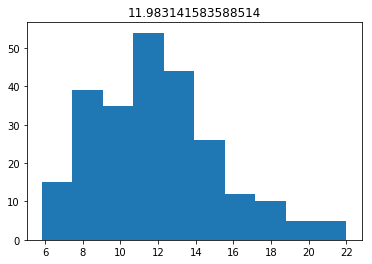

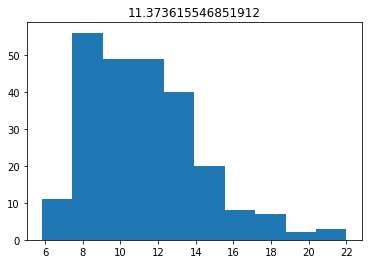

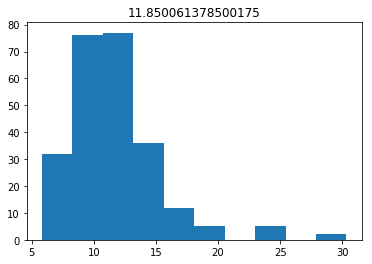

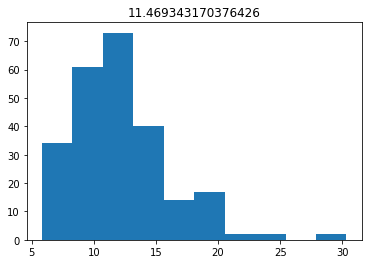

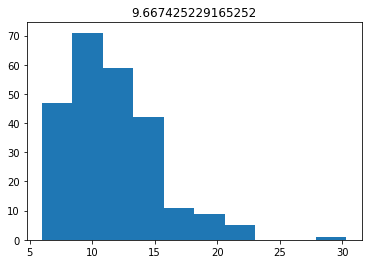

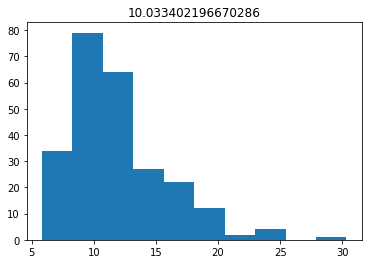

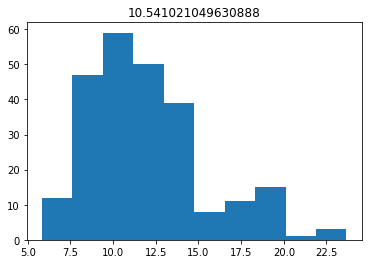

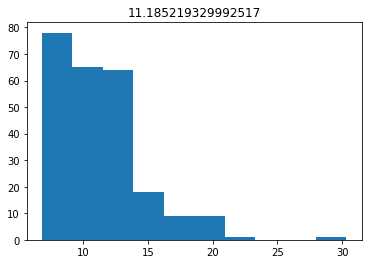

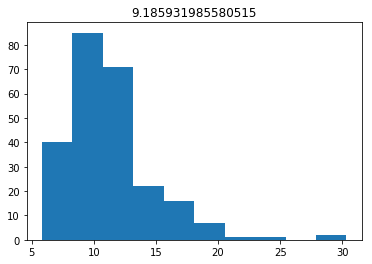

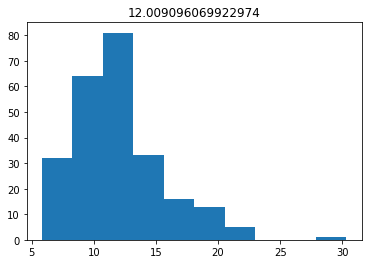

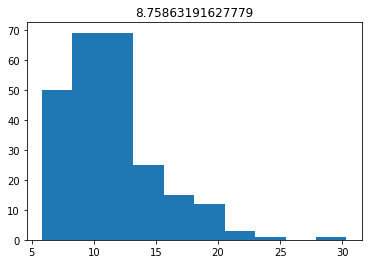

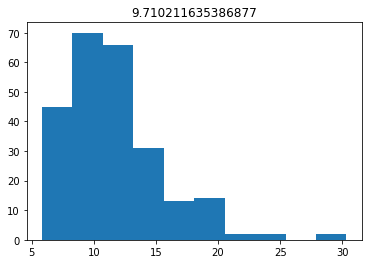

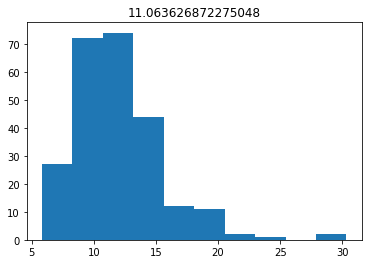

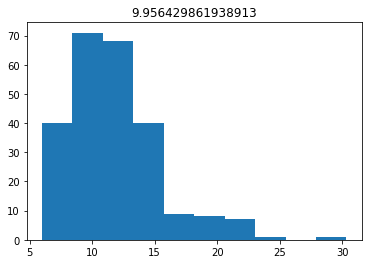

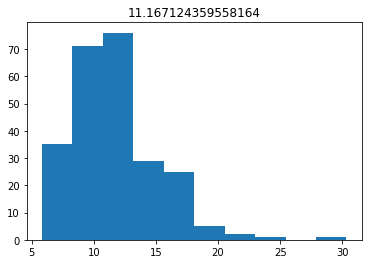

In [244]:
def bootstrap_plot(data, calc, draws):
    out = []
    # main loop
    i = 0
    while i < draws:
        plt.figure(i)
        resampled_data = np.random.choice(data, len(data), replace=True)
        a = plt.hist(resampled_data)
        o = calc(resampled_data)
        plt.title(o)
        out.append(o)
        i += 1
    return np.array(out)


data = T

Trange = np.linspace(np.min(data), np.max(data), 1000)
fs_here = len(Trange)/(Trange.max() - Trange.min())
interp_func = interp1d(range(0, len(Trange)), Trange, fill_value='extrapolate', kind='cubic')

def histogram_calc(data):
    kernel = gaussian_kde(data)
    p_index, p_err = peak_fit(kernel(Trange), kernel(Trange).argmax(), window=21)
    kde_peak = interp_func(p_index)
    #kde_peak_err = p_err/fs_here
    return kde_peak

out_hist = bootstrap_plot(data, histogram_calc, 15)

In [242]:
print(f'{np.mean(out_hist):.3} +- {np.std(out_hist):.3}')

10.5 +- 1.09


## Dataset 4 (control experiment repeat)

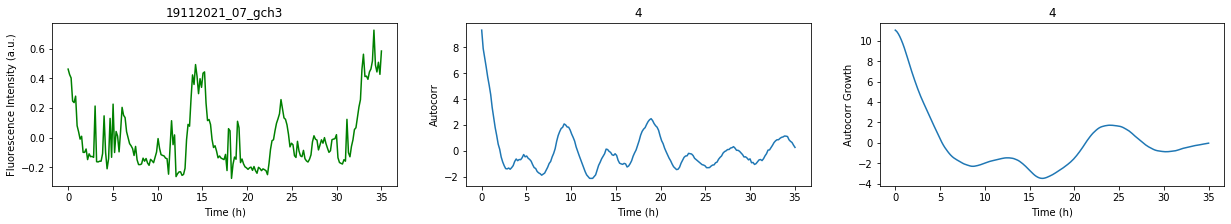

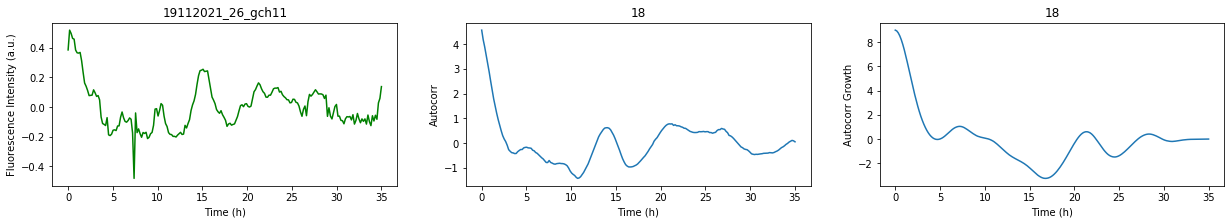

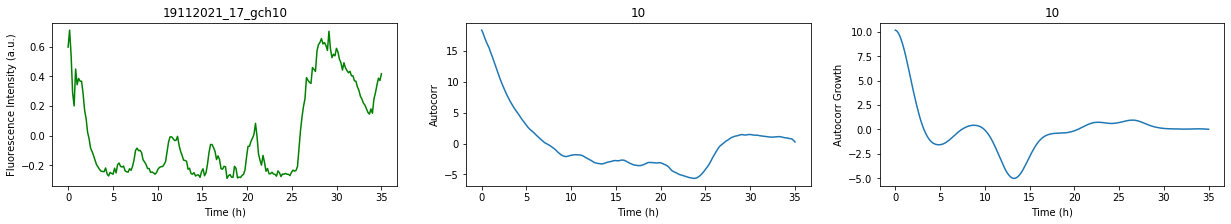

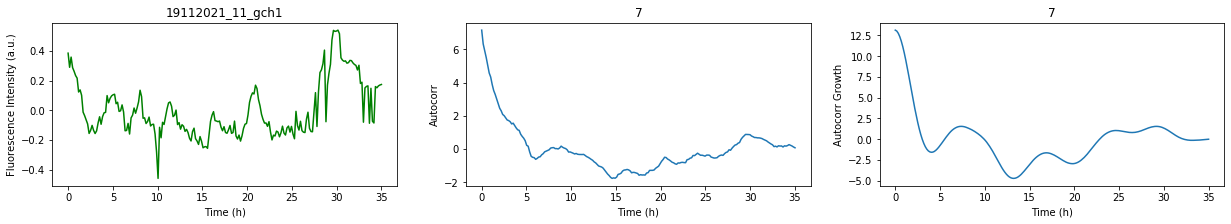

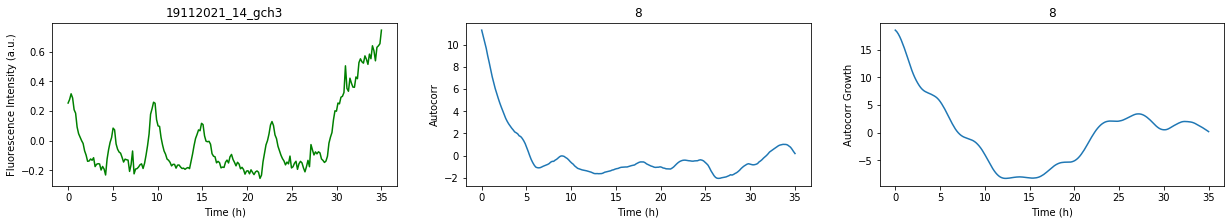

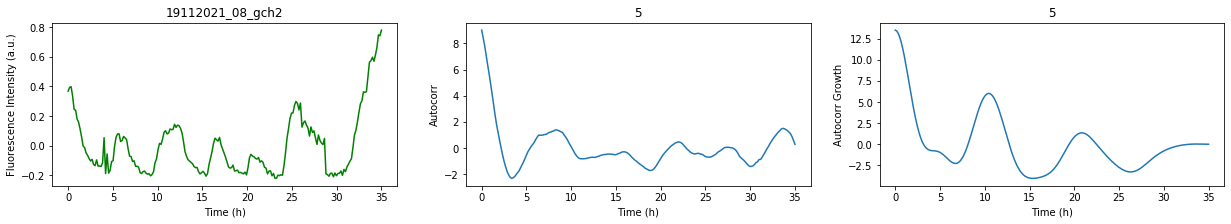

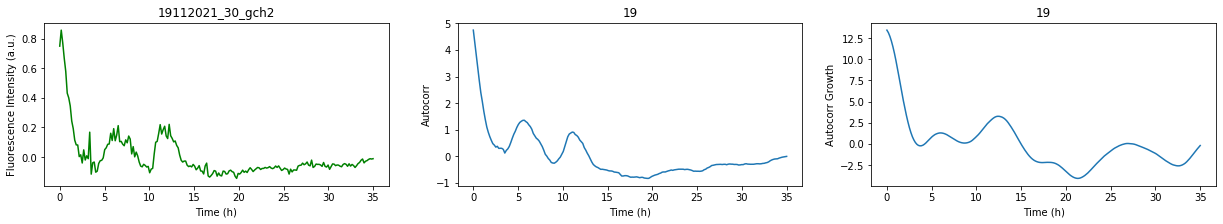

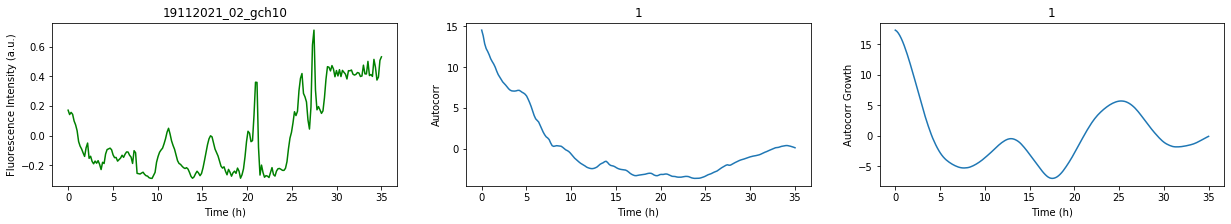

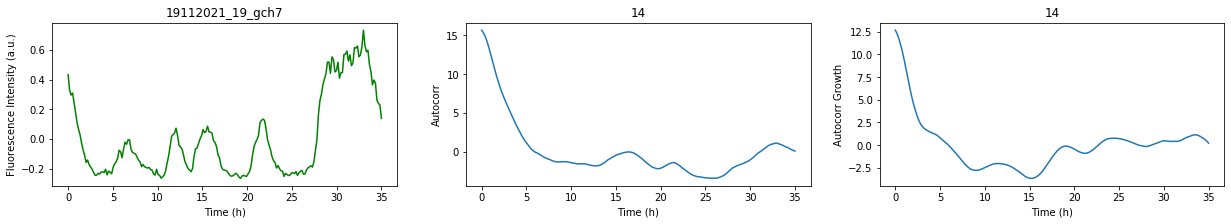

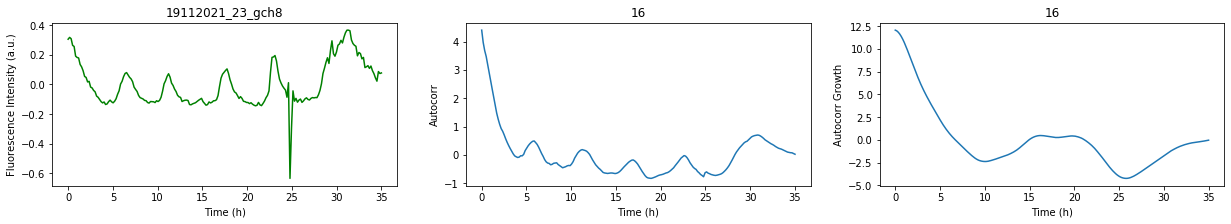

In [5]:
path = '../200721_split/200721_traces.csv'
df = pd.read_csv(path)

fs = 6
t_cutoff = 35

# selection of traces
selection = df['id'].unique()  # all

autocorr_growth_sum = np.zeros(fs*t_cutoff)
for i in np.random.choice(selection, 10, replace=False):
#for i in [44, 60]:
    name, t, sig = load_data(i, df)
    t_interp, s_interp, i_cutoff = sig_interp(sig, t, t_cutoff, fs)
    
    # calculate growth rate
    name, t, t2, area, area2, switch = load_area(i, df)
    div = div_events(t, area)
    div2 = div_events(t2, area2)
    g_rate = growth_rate(t, div, 6)
    g_rate2 = growth_rate(t2, div2, 6)
    cond = (not switch is None) & (not np.isnan(switch))
    if cond:
        g_rate_switch = np.concatenate([g_rate[:int(switch)], g_rate2[int(switch):]])
        t_switch = np.concatenate([t[:int(switch)], t2[int(switch):-1]])
    else: 
        g_rate_switch = g_rate
        t_switch = t[:-1]
    t_g_interp, g_interp, i_cutoff = sig_interp(g_rate_switch, t_switch, t_cutoff, fs)
    autocorr_growth_sum += autocorr(g_interp)
    
    
    plt.figure(figsize=(21, 3))
    plt.subplot(131)
    plt.plot(t_interp, s_interp, 'g')
    plt.xlabel('Time (h)')
    plt.ylabel('Fluorescence Intensity (a.u.)')
    plt.title(name)

    plt.subplot(132)
    plt.plot(t_interp, autocorr(s_interp))
    plt.title(i)
    plt.xlabel('Time (h)')
    plt.ylabel('Autocorr')
    
    plt.subplot(133)
    plt.plot(t_interp, autocorr(g_interp))
    plt.title(i)
    plt.xlabel('Time (h)')
    plt.ylabel('Autocorr Growth')

5.201342281879195


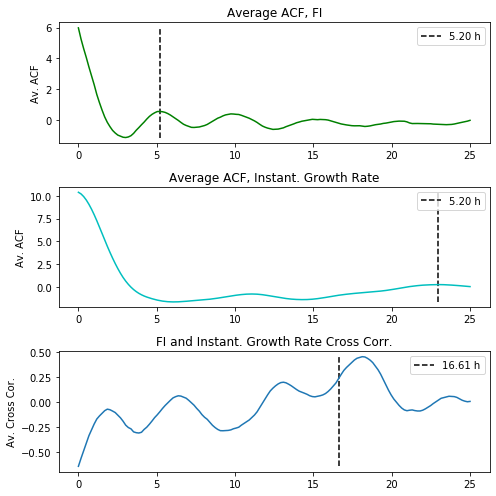

In [10]:
plt.figure(figsize=(7, 7))

plt.subplot(311)
plt.plot(t_interp, autocorr_avg, 'g-')
#plt.plot(t_interp, autocorr_growth_avg, label=f'growth, N = {len(selection)}')
#T_max = 1/freq_from_autocorr(autocorr_avg, 6)
T_max = t_interp[int(autocorr_first_peak(autocorr_avg[:150]))]
print(T_max)
plt.vlines(T_max, ymin=np.min(autocorr_avg), ymax=np.max(autocorr_avg), label=f'{T_max:.2f} h', linestyles='dashed')
plt.ylabel('Av. ACF')
plt.title('Average ACF, FI')
plt.legend()
plt.tight_layout()

plt.subplot(312)
plt.plot(t_g_interp, autocorr_growth_avg, 'c-')
T_max_g = t_g_interp[int(autocorr_first_peak(autocorr_growth_avg[:150]))]
plt.vlines(T_max_g, ymin=np.min(autocorr_growth_avg), ymax=np.max(autocorr_growth_avg), label=f'{T_max:.2f} h', linestyles='dashed')
plt.ylabel('Av. ACF')
plt.title('Average ACF, Instant. Growth Rate')
plt.legend()

plt.subplot(313)
plt.ylabel('Av. Cross Cor.')
plt.title(f'FI and Instant. Growth Rate Cross Corr.')
plt.plot(t_interp, crosscorr_avg)
T_max = t_interp[int(autocorr_first_peak(crosscorr_avg[:100]))]
plt.vlines(T_max, ymin=np.min(crosscorr_avg), ymax=np.max(crosscorr_avg), label=f'{T_max:.2f} h', linestyles='dashed')
plt.legend()


plt.tight_layout()
